In [1]:
from netCDF4 import Dataset
import numpy as np
from numpy import sin, cos, tan
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib inline

In [2]:
ellinkm = 40
ds = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/1.nc_{0:04d}_Filtered.nc'.format(ellinkm))
#ds = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/1_fullVel.nc_0080_Filtered.nc')
ds_unfilt = Dataset('/scratch/srai6/EddyKillingPaper3/CESM/1.nc')
gridDS= Dataset('/scratch/srai6/EddyKillingPaper3/CESM/newGlobalGrid_tripolePOP_0.1deg.nc')

In [3]:
def log_to_sph(U_log, V_log, ANGLE):
    #ANGLE in radians
    U_Sph = U_log * np.cos(ANGLE) - V_log * np.sin(ANGLE)
    V_Sph = U_log * np.sin(ANGLE) + V_log * np.cos(ANGLE)
    return U_Sph, V_Sph


def sph_to_log(U_Sph, V_Sph, ANGLE):
    #ANGLE in radians logical direction w.r.t. lat line
    U_Log = U_Sph * np.cos(ANGLE) + V_Sph * np.sin(ANGLE)
    V_Log = V_Sph * np.cos(ANGLE) - U_Sph * np.sin(ANGLE)
    return U_Log, V_Log

In [4]:
DX = np.array(gridDS.variables['DXU'])
DY = np.array(gridDS.variables['DYU'])
KMT = np.array(gridDS.variables['KMT'])
ULAT = np.array(gridDS.variables['ULAT'])
UAREA = np.array(gridDS.variables['UAREA'])
ANGLE = np.array(gridDS.variables['ANGLE'])
ANGLE[abs(ANGLE)>180] = 0.0
landMask = KMT < 30

In [5]:
ubar = ds.variables['UVEL'][:,:]
vbar = ds.variables['VVEL'][:,:]

#ubar, vbar = sph_to_log(ubar, vbar, ANGLE)

# ubar[landMask] = 0.0
# vbar[landMask] = 0.0

tx = ds.variables['SUF'][:,:]
ty = ds.variables['SVF'][:,:]
#tx, ty = sph_to_log(tx, ty, ANGLE)

# tx[landMask] = 0.0
# ty[landMask] = 0.0

EPPA = ds.variables['EddyPowerPerArea'][:,:]

In [6]:
def GetGradient(Array2D, DXU, DYU):
    p = -1
    m = 1
    x = 1
    y = 0
    topRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (p,p), axis=(y,x)) +\
               np.roll(Array2D, p, axis=y))
    
    topLeft = 0.25*(Array2D + np.roll(Array2D, p, axis=y) +\
               np.roll(Array2D, (p,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=x))
    
    bottomRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (m,p), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    bottomLeft = 0.25*(Array2D + np.roll(Array2D, m, axis=x) +\
               np.roll(Array2D, (m,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    gradx = 0.5*(topRight + bottomRight - topLeft - bottomLeft)/DX
    grady = 0.5*(topRight + topLeft - bottomRight - bottomLeft)/DY
    
    return gradx, grady


def getModel3(uvel, vvel, taux, tauy, DXU, DYU, ANGLE, ellInKm, ULAT):
    #M2 = 4*0.12412465206752543  #0.13526
    M2 = 4*0.147 
#    M2 = 4*0.13526 #0.12412465206752543
#     M2 = np.ones(ULAT.shape)
#     c = 0.145482
#     m = -0.00000011
#    M2 = 2*(c + m*ULAT)
    dx_u, dy_u = GetGradient(uvel, DXU, DYU)
    dx_v, dy_v = GetGradient(vvel, DXU, DYU)
    
    dx_taux, dy_taux = GetGradient(taux, DXU, DYU)
    dx_tauy, dy_tauy = GetGradient(tauy, DXU, DYU)
    
    model = dx_taux*dx_u + dx_tauy*dx_v + dy_taux*dy_u + dy_tauy*dy_v
    model *=  1/2 * M2* (ellInKm*1e5)**2
    
    return model

In [7]:
model3 = getModel3(tx, ty, ubar, vbar, DX, DY, ANGLE, ellinkm, ULAT)


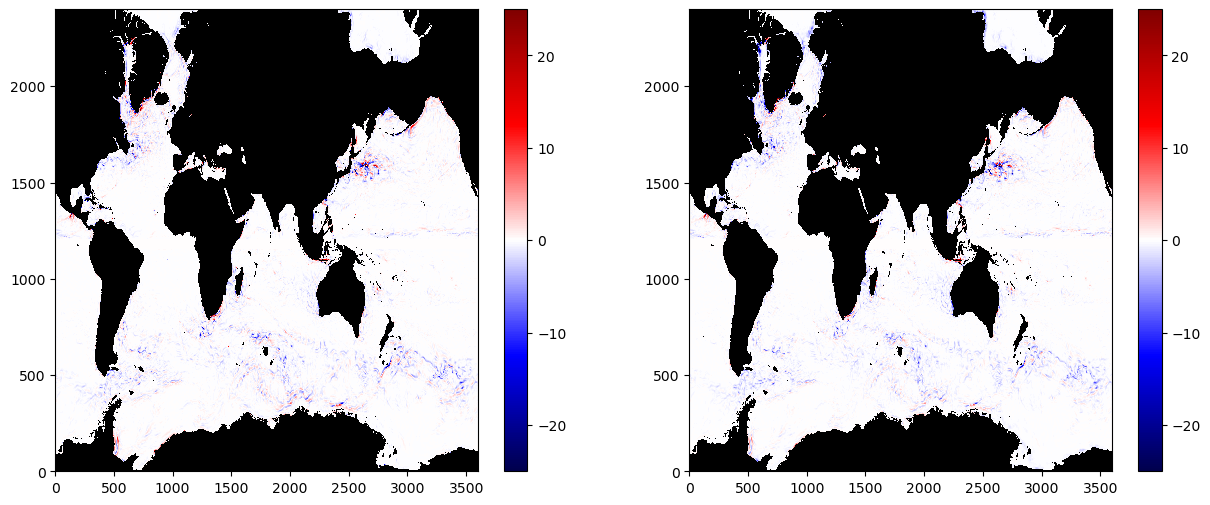

In [8]:
EPPA[landMask] = float('nan')
model3[landMask] = float('nan')
EPPA[abs(EPPA)>100] = float('nan')
model3[abs(model3)>100] = float('nan')

cmap=plt.get_cmap('seismic').copy()
cmap.set_bad('k')
v = 25

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
m = ax[0].pcolormesh(model3, vmin = -v, vmax=v, cmap=cmap)
plt.colorbar(m, ax=ax[0])

m = ax[1].pcolormesh(EPPA, vmin = -v, vmax=v, cmap=cmap)
plt.colorbar(m, ax=ax[1])

In [9]:
x = EPPA.flatten()
y = model3.flatten()
msk = np.isnan(x) + np.isnan(y)
msk1 = np.isinf(x) + np.isinf(y)
msk2 = (x == 0) + (y ==0)
msk += msk1 + msk2
x = x[~msk]
y = y[~msk]
r = np.corrcoef(x,y)[0, 1]
print(r)

0.8232592906799008


0.9029733960828706
-4.34297472244777 -3.0623724012046973


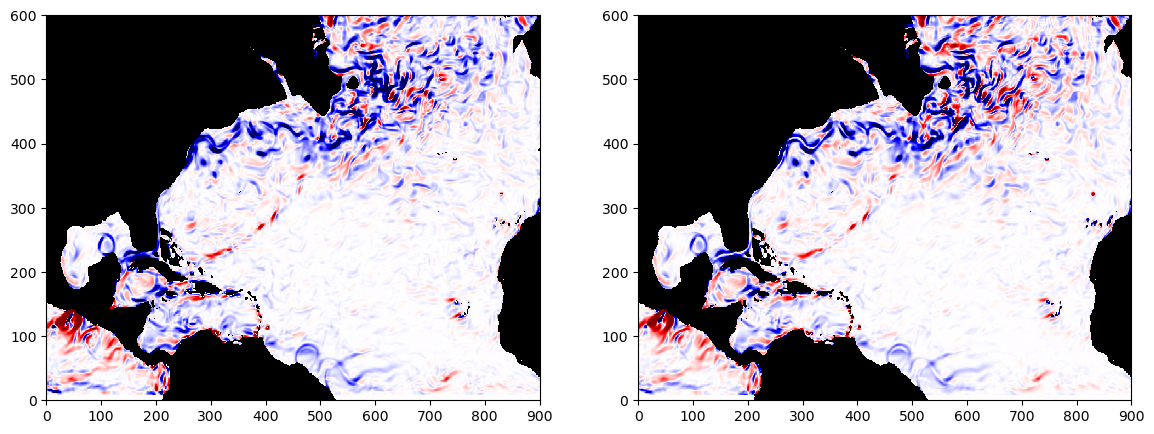

In [10]:
y1 = 1200
y2 = 1800
x1 = 100
x2 = 1000
        
d = 4
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].pcolormesh(EPPA[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap)
ax[1].pcolormesh(model3[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap)

x = EPPA[y1:y2,x1:x2].flatten()
y = model3[y1:y2,x1:x2].flatten()
msk = np.isnan(x) + np.isnan(y)
msk1 = np.isinf(x) + np.isinf(y)
msk2 = (x == 0) + (y ==0)
msk += msk1 + msk2
r = np.corrcoef(x[~msk], y[~msk])[0, 1]
print(r)
print(np.nansum(EPPA[y1:y2,x1:x2] * UAREA[y1:y2,x1:x2])*(1e-16), np.nansum(model3[y1:y2,x1:x2] * UAREA[y1:y2,x1:x2])*(1e-16),  )

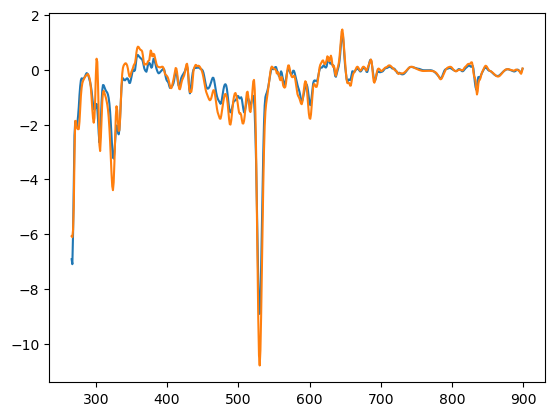

In [11]:
plt.plot(EPPA[y1:y2,x1:x2][400,:])
plt.plot(model3[y1:y2,x1:x2][400,:])

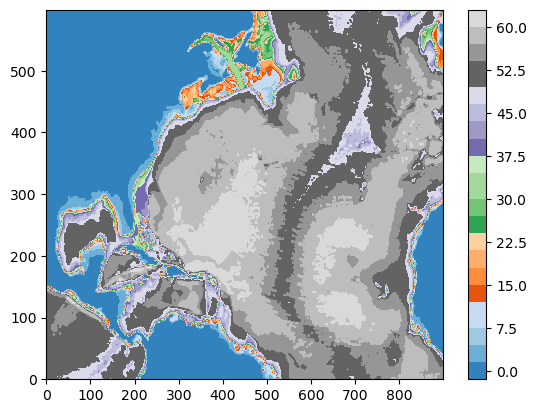

In [12]:
plt.contourf(KMT[y1:y2,x1:x2],levels=50,cmap='tab20c')
plt.colorbar()